<a href="https://colab.research.google.com/github/shoaibrayeen/API-Testing-Automation/blob/master/Object%20Detection/FaceMask_Detection_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Drive Link - [DataSet for Face Mask Detection](https://drive.google.com/drive/folders/1JN8yc-0TU05M-b6_d_qMAmHOqmdCTQGM?usp=sharing)

In [3]:
import os
from os import getcwd, listdir
import zipfile
import random
import shutil
import numpy as np
import sys
from pathlib import Path

from shutil import copyfile
import imutils
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import PIL
import io
import html
import time

from google.colab import drive
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.inception_v3 import preprocess_input

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [4]:
%load_ext autoreload
%autoreload 2
base = Path('/gdrive/My Drive/face-mask-dataset/')
sys.path.append(str(base))

In [5]:
zip_path = base/'face-mask-dataset.zip'
!cp "{zip_path}" .
!unzip -q face-mask-dataset.zip
!rm face-mask-dataset.zip

In [6]:
base_dir = 'face-mask-dataset/'
train_dir = os.path.join(base_dir, 'data')
val_dir = os.path.join(base_dir, 'validation/test')
category_train = os.listdir(train_dir)
category_val = os.listdir(val_dir)
print(train_dir, val_dir, category_train, category_val)

face-mask-dataset/data face-mask-dataset/validation/test ['with_mask', 'without_mask'] ['with_mask', 'without_mask']


In [7]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 1
ncols = 8

# Index for iterating over images
pic_index = 0

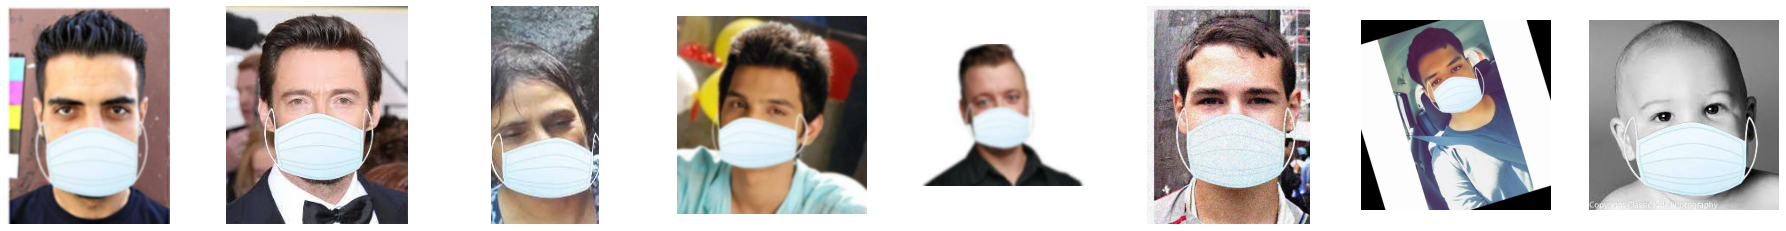

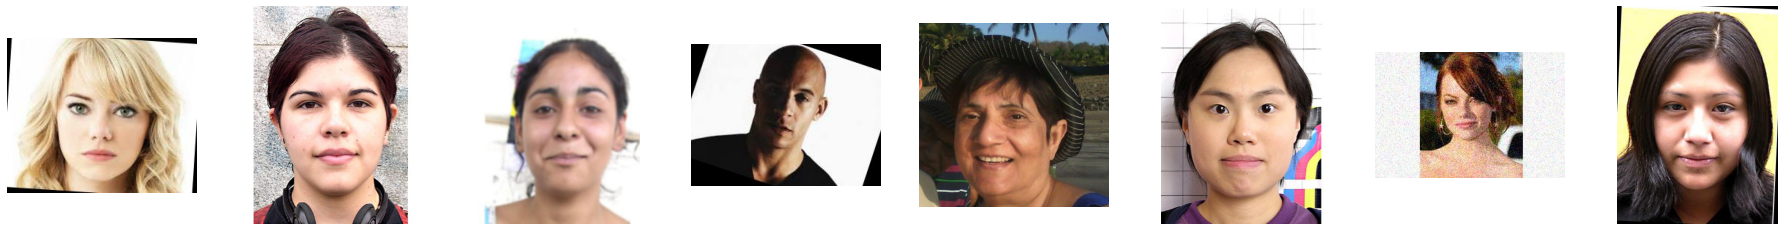

In [8]:
pic_index += 8

for it in category_train:
  # Set up matplotlib fig, and size it to fit 4x4 pics
  fig = plt.gcf()
  fig.set_size_inches(ncols * 4, nrows * 4)
  train_cat_dir = os.path.join(train_dir, it)
  train_cat_fnames = os.listdir(train_cat_dir)
  next_pix = [os.path.join(train_cat_dir, fname) 
                  for fname in train_cat_fnames[pic_index-8:pic_index]]

  for i, img_path in enumerate(next_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

  plt.show()

In [9]:
print("The number of images with facemask labelled - Training - 'yes':",len(os.listdir(train_dir + '/with_mask')))
print("The number of images with facemask labelled - Training - 'no':",len(os.listdir(train_dir + '/without_mask')))
print("The number of images with facemask labelled - Validation - 'yes':",len(os.listdir(val_dir + '/with_mask')))
print("The number of images with facemask labelled - Validation - 'no':",len(os.listdir(val_dir + '/without_mask')))

The number of images with facemask labelled - Training - 'yes': 690
The number of images with facemask labelled - Training - 'no': 686
The number of images with facemask labelled - Validation - 'yes': 97
The number of images with facemask labelled - Validation - 'no': 97


In [10]:
def data_summary(main_path, dataset_name):
    
    yes_path = main_path+'/with_mask'
    no_path = main_path+'/without_mask'
        
    # number of files (images) that are in the the folder named 'yes' that represent tumorous (positive) examples
    m_pos = len(listdir(yes_path))
    # number of files (images) that are in the the folder named 'no' that represent non-tumorous (negative) examples
    m_neg = len(listdir(no_path))
    # number of all examples
    m = (m_pos+m_neg)
    
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m
    
    print(f"Number of examples for {dataset_name}: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of positive examples: {m_pos}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of negative examples: {m_neg}") 
    
data_summary(train_dir, 'Training')
data_summary(val_dir, 'Validation')

Number of examples for Training: 1376
Percentage of positive examples: 50.145348837209305%, number of positive examples: 690
Percentage of negative examples: 49.854651162790695%, number of negative examples: 686
Number of examples for Validation: 194
Percentage of positive examples: 50.0%, number of positive examples: 97
Percentage of negative examples: 50.0%, number of negative examples: 97


In [11]:
train_files = sum([len(files) for i, j, files in os.walk(train_dir)])
val_files = sum([len(files) for i, j, files in os.walk(val_dir)])
print(train_files, val_files)

1376 194


In [78]:
n_classes = 5
epochs = 30
nb_train_samples = train_files
nb_validation_samples = val_files
num_epochs = epochs

img_width, img_height = 150, 150
train_data_dir = train_dir
validation_data_dir = val_dir
batch_size = 8

In [80]:
# Our input feature map is 150x150x3: 165x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(img_width, img_height, 3))

# First convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 128 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 256 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

In [81]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

x = layers.Dropout(0.2)(x)

# Create a fully connected layer with ReLU activation and 128 hidden units
x = layers.Dense(128, activation='relu')(x)

# Create output layer with 5 nodes and softmax activation
output = layers.Dense(2, activation='softmax')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

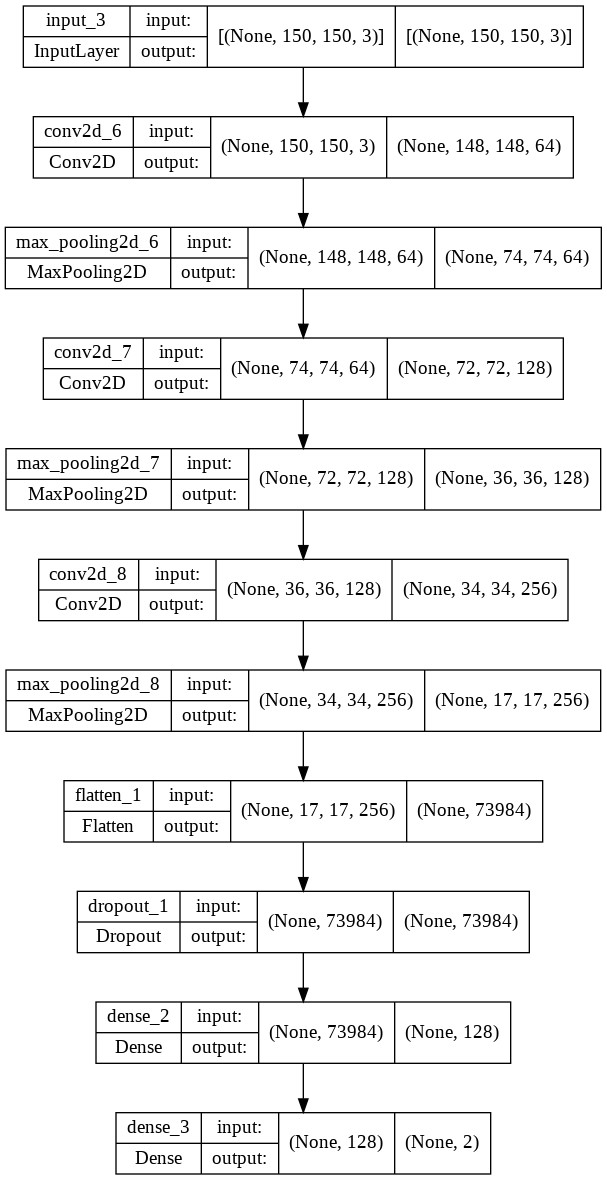

In [82]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [16]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 256)       295168

In [83]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [86]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    batch_size=batch_size, 
                                                    target_size=(150, 150))

validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(val_dir, 
                                                         batch_size=batch_size, 
                                                         target_size=(150, 150))

checkpoint = ModelCheckpoint('model-{epoch:03d}.model', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')

Found 1376 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


In [87]:
history = model.fit_generator(train_generator,
                              epochs=num_epochs,
                              validation_data=validation_generator,
                              callbacks=[checkpoint])

Epoch 1/30
  1/172 [..............................] - ETA: 14s - loss: 0.3258 - accuracy: 0.8750

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


172/172 [==============================] - 14s 83ms/step - loss: 0.1971 - accuracy: 0.9237 - val_loss: 0.0758 - val_accuracy: 0.9588
Epoch 2/30
172/172 [==============================] - 14s 84ms/step - loss: 0.1691 - accuracy: 0.9419 - val_loss: 0.0623 - val_accuracy: 0.9639
Epoch 3/30
172/172 [==============================] - 14s 83ms/step - loss: 0.2427 - accuracy: 0.9070 - val_loss: 0.0504 - val_accuracy: 0.9794
Epoch 4/30
172/172 [==============================] - 13s 76ms/step - loss: 0.1680 - accuracy: 0.9353 - val_loss: 0.1395 - val_accuracy: 0.9278
Epoch 5/30
172/172 [==============================] - 13s 76ms/step - loss: 0.1540 - accuracy: 0.9491 - val_loss: 0.1082 - val_accuracy: 0.9485
Epoch 6/30
172/172 [==============================] - 13s 76ms/step - loss: 0.1154 - accuracy: 0.9557 - val_loss: 0.0958 - val_accuracy: 0.9536
Epoch 7/30
172/172 [==============================] - 14s 83ms/step - loss: 0.0968 - accuracy: 0.9688 - val_loss: 0.0064 - val_accuracy: 1.0000
Epo

In [88]:
#Show Model Stats

def find_model_stats(stats, title):
  min_val = min(stats)
  max_val = max(stats)
  avg_val = (min_val + max_val)/2
  diff = max_val - avg_val
  print(title + ' -> %.3f' % avg_val + ' +- ' + '%.6f' % diff)

print("============Model Stats=================")
find_model_stats(history.history['accuracy'], 'Accuracy')
find_model_stats(history.history['val_accuracy'], 'Validation Accuracy')
find_model_stats(history.history['loss'], 'Loss')
find_model_stats(history.history['val_loss'], 'Validation Loss')

============Model Stats=================
Accuracy -> 0.948 +- 0.041424
Validation Accuracy -> 0.936 +- 0.064433
Loss -> 0.139 +- 0.103907
Validation Loss -> 0.291 +- 0.291108


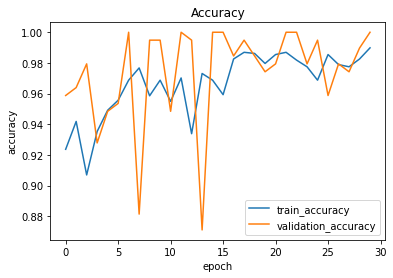

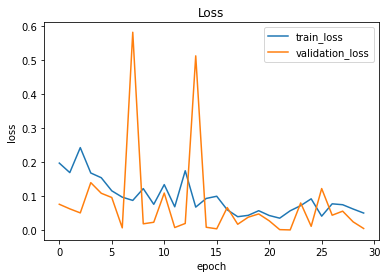

In [94]:
# Plot the results
def plot_accuracy(history, title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history, title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history, 'Accuracy')
plot_loss(history, 'Loss')

In [90]:
# Haar cascade works as a classifier. It classifies positive data points
# that are part of our detected object and negative data points 
# that don't contain our object. Haar cascades are fast and can work well in real-time.

face_cascade = cv2.CascadeClassifier(base_dir + 'haarcascade_frontalface_default.xml')

In [91]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [92]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [98]:
# start streaming video from webcam
video_stream()

labels_dict={0:'without_mask',1:'with_mask'}
color_dict={0:(0,0,255),1:(0,255,0)}

# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
size = 4

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # mini = cv2.resize(img, (img.shape[1] // size, img.shape[0] // size))

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    # for (x,y,w,h) in faces:
    #   bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
    
    for (x, y, w, h) in faces:
        #Save just the rectangle faces in SubRecFaces
        face_img = img[x:x+w, y:y+h]
        resized = cv2.resize(face_img, (150, 150), interpolation = cv2.INTER_AREA)
        # print('Resized Dimensions : ',resized.shape, resized.size)
        reshaped = np.reshape(resized, (1, 150, 150, 3))
        reshaped = np.vstack([resized])
        reshaped = np.expand_dims(resized, axis=0)
        # print(reshaped.shape)
        result = model.predict(reshaped)
        label=np.argmax(result, axis=1)[0]
        # print(result, label)
        bbox_array = cv2.rectangle(bbox_array, (x, y), (x+w, y+h), color_dict[label], 2)
        bbox_array = cv2.rectangle(bbox_array, (x, y-40), (x+w, y), color_dict[label], -1)
        bbox_array = cv2.putText(bbox_array, labels_dict[label], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)
    

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>